In [10]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from langchain_community.vectorstores import FAISS
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_classic.schema import Document
from dotenv import load_dotenv
import os
from langchain_community.embeddings import HuggingFaceEmbeddings
import PyPDF2 as pdf

In [3]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [4]:
llm = ChatGroq(model = "llama-3.3-70b-versatile")

In [6]:
embeddings = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-MiniLM-L6-v2")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30980\2723708130.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-MiniLM-L6-v2")


In [9]:
class AgentState(TypedDict):
    question: str
    documents: List[Document]
    answer: str
    needs_retrieval: bool

In [13]:
def get_text(pdf_path):
    with open(pdf_path, "rb") as file:
        reader = pdf.PdfReader(file)
        texts = ""
        for page in reader.pages:
            extracted = page.extract_text()
            if extracted:
                texts += extracted
        return texts

In [14]:
texts = get_text("C:/Users/Lenovo/Desktop/datapdf/kharidaran.pdf")

In [16]:
def get_chunks(texts):
    splitter = RecursiveCharacterTextSplitter(
        separators = ["\n", "\n\n", " "],
        chunk_size = 1000,
        chunk_overlap = 150
    )
    chunks = splitter.split_text(texts)
    docs = [Document(page_content = chunk) for chunk in chunks]
    return docs 

In [17]:
documents = get_chunks(texts)

In [19]:
vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(k = 2)

In [41]:
def decide_retrieval(state: AgentState) -> AgentState:
    """
    Decide if we need to retrieve documents based on the question
    """
    question = state["question"]

    retrieval_keywords = ["چی", "چطوری", "توضیح بده", "تشریح کن", "به من بگو", "چرا", "آیا", "چگونه", "چه"]
    needs_retrieval = any(keyword in question for keyword in retrieval_keywords)
    
    return {**state, "needs_retrieval": needs_retrieval}

In [42]:
def retrieve_documents(state: AgentState) -> AgentState:
    """
    Retrieve relevant documents based on the question
    """
    question = state["question"]
    documents = retriever.invoke(question)

    return {**state, "documents": documents}

In [43]:
def generate_answer(state: AgentState) -> AgentState:
    """"
    Generate an answer using the retrieved documents or direct response
    """
    question = state["question"]
    documents = state.get("documents", [])

    if documents:
        context = "\n\n".join([doc.page_content for doc in documents])
        prompt = f"""شما یک متخصص خبره در پاسخگویی به سوالات بر اساس متن ارائه شده می باشید که دقیق ترین و کارآمدترین پاسخ ها را تولید می کند. بر اساس متن ارائه شده، یک پاسخ به طول 500 کلمه ایجاد کنید به طوری که به سوال کاربر به بهترین شکل ممکن پاسخ داده شود.
هدف این است که کاربر پاسخ سوال خود را به بهترین شکل، دقیق و جامع بگیرد.
متن: 
{context}

سوال: {question}

پاسخ: """
    else:
        prompt = f"""شما یک متخصص خبره در زمینه پاسخگویی به سوالات ارائه شده می باشید که دقیق ترین و کارآمدترین پاسخ ها را تولید می کند.
بر اساس سوال مطرح شده، یک پاسخ به طول 2000 کلمه ایجاد کنید به طوری که 500 کلمه برای بخش مقدمه، 1000 کلمه برای بخش اصلی پاسخ و 500 کلمه نیز برای بخش نتیجه گیری باشد به طوری که به سوال کابر به بهترین شکل ممکن پاسخ داده شود. توجه داشته باش که نام بخش ها در پاسخی که ارائه می کنی ذکر نشود.
در بخش مقدمه باید یک پیش زمینه کلی از موضوعی که در سوال مطرح شده است را به کاربر بدهی به طوری که برای کاربر علاقه ای ایجاد شود تا ادامه پاسخ را مشتاقانه بخواند.
در بخش اصلی پاسخ، باید پاسخی دقیق و جامع به سوال کاربر بدهی به طوری که پاسخ اصلی، ساختارمند و واضح باشد.
در بخش نتیجه گیری نیز از متن هایی که در بخش مقدمه و بخش اصلی پاسخ تولید کرده ای، یک نتیجه گیری کن و آن را به عنوان بخش نتیجه گیری مطرح کن.
دقت داشته باش که نام بر بخش نباید آورده شود بلکه هر بخش را در پاراگراف های جداگانه از یکدیگر تمییز بده.
هدف این است که کاربر پاسخ سوال خود را به بهترین شکل، دقیق و جامع بگیرد.
                
سوال: {question}"""
    
    response = llm.invoke(prompt)
    answer = response.content

    return {**state, "answer": answer}

In [44]:
def should_retrieve(state: AgentState) -> str:
    """
    Determine the next step based on retrieval decision
    """
    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

In [45]:
workflow = StateGraph(AgentState)

workflow.add_node("decide", decide_retrieval)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)

workflow.set_entry_point("decide")

workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

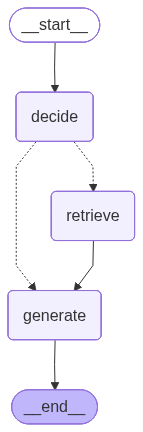

In [46]:
app

In [47]:
def ask_question(question: str):
    """
    Helper function to ask a question and get an answer
    """
    initial_state = {
        "question": question,
        "documents": [],
        "answer": "",
        "needs_retrieval": False
    }

    result = app.invoke(initial_state)
    return result

In [48]:
question1 = "چرا باید در سایت ثبت نام کنم؟"
result1 = ask_question(question1)
result1

{'question': 'چرا باید در سایت ثبت نام کنم؟',
 'documents': [Document(id='e5e9d410-c37d-4a37-acdc-dbbaa09ff4a2', metadata={}, page_content='چرا باید در سایت ثبتنام کنم؟   \nثبتنام در سایت برای دسترسی به تمامی خدمات ضروری است. پس از ثبت  نام، شما می توانید سفارشات \nخود را پیگیری کنید، از پیشنهادات ویژه و تخفیف ها بهره مند شوید، تاریخچه خریدهایتان را مشاهده کنید  \nو به راحتی نقد و بررسی ها را ثبت کنید. همچنین، ثبت نام برای حفاظت از امنیت خرید و جلوگیری از تقلب   \nالزامی است. \nآیا می توانم بدون ثبت نام در سایت خرید کنم؟  \nخیر، برای خرید از سایت، ابتدا باید حساب کاربری ایجاد کنید. ثبت نام به شما اجازه میدهد تا فرایند خرید   \nخود را سریع تر و ایمن تر انجام دهید. همچنین، پس از خرید، می توانید وضعیت سفارشات خود را دنبال  \nکرده و از خدمات پشتیبانی استفاده کنید . \nآیا مسئولیت حفظ اطالعات حساب کاربری بر عهده من است؟  \nبله، مسئولیت محافظت از اطالعات حساب کاربری شما  کامالً بر عهده خودتان است. شما باید از یک رمز  \nعبور قوی و منحصر به فرد استفاده کنید و از به اشتراک گذاشتن آن با دیگران خو

In [49]:
question2 = "آیا می توانم بدون ثبت نام در سایت خرید کنم؟"
result2 = ask_question(question2)

print(f"Question: {question2}")
print(f"Retrieved documents: {len(result2['documents'])}")
print(f"Answer: {result2['answer']}")
print("\n" + "=" * 50 + "\n")

Question: آیا می توانم بدون ثبت نام در سایت خرید کنم؟
Retrieved documents: 4
Answer: با توجه به متن ارائه شده، پاسخ به سوال "آیا می توانم بدون ثبت نام در سایت خرید کنم?" به صورت زیر است:

خیر، برای خرید از سایت، ابتدا باید حساب کاربری ایجاد کنید. ثبت نام به شما اجازه می‌دهد تا فرایند خرید خود را سریع‌تر و ایمن‌تر انجام دهید. همچنین، پس از خرید، می‌توانید وضعیت سفارشات خود را دنبال کرده و از خدمات پشتیبانی استفاده کنید.

ثبت نام در سایت برای دسترسی به تمامی خدمات ضروری است. پس از ثبت نام، شما می‌توانید سفارشات خود را پیگیری کنید، از پیشنهادات ویژه و تخفیف‌ها بهره‌مند شوید، تاریخچه خریدهایتان را مشاهده کنید و به راحتی نقد و بررسی‌ها را ثبت کنید. به علاوه، ثبت نام برای حفاظت از امنیت خرید و جلوگیری از تقلب الزامی است.

برای خرید از سایت، ایجاد حساب کاربری الزامی است و نمی‌توانید بدون ثبت نام خرید کنید. پس از ثبت نام، می‌توانید از خدمات سایت به طور کامل استفاده کنید و از مزایای آن بهره‌مند شوید.

در مجموع، ثبت نام در سایت یک مرحله ضروری برای خرید از سایت است و بدون آن نمی‌توانید خرید کنید.

In [50]:
question3 = "هوش مصنوعی چیست؟"
result3 = ask_question(question3)

print(f"Question: {question3}")
print(f"Answer: {result3['answer']}")
print("\n" + "=" * 50 + "\n")

Question: هوش مصنوعی چیست؟
Answer: هوش مصنوعی (AI) یک رشته علمی و فناوری است که به طراحی و توسعه سیستم‌ها و ماشین‌هایی می‌پردازد که بتوانند مانند انسان فکر کنند، یاد بگیرند و عمل کنند. هوش مصنوعی از ترکیب علوم کامپیوتر، ریاضیات، روان‌شناسی و مهندسی تشکیل شده است و هدف آن ایجاد ماشین‌هایی است که بتوانند وظایف پیچیده‌ای را که معمولاً به هوش انسانی نیاز دارد، انجام دهند.

هوش مصنوعی شامل چندین زیررشته است، از جمله:

1. یادگیری ماشین (Machine Learning): این زیررشته به مطالعه الگوریتم‌ها و روش‌های یادگیری ماشین می‌پردازد، به طوری که ماشین‌ها بتوانند از داده‌ها و تجربیات خود یاد بگیرند و بهبود یابند.
2. پردازش زبان طبیعی (Natural Language Processing): این زیررشته به مطالعه الگوریتم‌ها و روش‌های پردازش زبان طبیعی می‌پردازد، به طوری که ماشین‌ها بتوانند زبان انسان را درک کنند و به آن پاسخ دهند.
3. بینایی ماشین (Computer Vision): این زیررشته به مطالعه الگوریتم‌ها و روش‌های بینایی ماشین می‌پردازد، به طوری که ماشین‌ها بتوانند تصاویر و ویدیوها را درک کنند و از آنها یاد بگیرند.
4. استنتاج و منطق (In